In [2]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import cell2location
import scvi

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text for PDFs

print("Import done!")

Global seed set to 0


Import done!


In [2]:
#defining where we save the results
results_folder = './results/hamstring_aug2022/'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map'

In [3]:
#loading visium data
adata_vis = sc.read_visium("./data/Hamstring/Ham1/", count_file='filtered_feature_bc_matrix.h5')
adata_vis.obs['sample'] = list(adata_vis.uns['spatial'].keys())[0]
adata_vis.var
adata_vis

/opt/lramosmu/miniconda3/envs/test_scvi16_cuda113/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 2981 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'sample'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

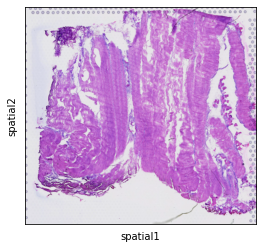

In [23]:
sc.pl.spatial(adata=adata_vis)

In [5]:
adata_vis.obs

,in_tissue,array_row,array_col,sample
AAACAAGTATCTCCCA-1,1,50,102,Ham1
AAACACCAATAACTGC-1,1,59,19,Ham1
AAACAGAGCGACTCCT-1,1,14,94,Ham1
AAACAGCTTTCAGAAG-1,1,43,9,Ham1
AAACAGGGTCTATATT-1,1,47,13,Ham1
...,...,...,...,...
TTGTTCAGTGTGCTAC-1,1,24,64,Ham1
TTGTTGTGTGTCAAGA-1,1,31,77,Ham1
TTGTTTCACATCCAGG-1,1,58,42,Ham1
TTGTTTCATTAGTCTA-1,1,60,30,Ham1


In [6]:
#renaming genes to ensembleids
adata_vis.var['SYMBOL'] = adata_vis.var_names
adata_vis.var.set_index('gene_ids', drop=True, inplace=True)
adata_vis.var

,feature_types,genome,SYMBOL
gene_ids,,,
ENSG00000243485,Gene Expression,GRCh38,MIR1302-2HG
ENSG00000237613,Gene Expression,GRCh38,FAM138A
ENSG00000186092,Gene Expression,GRCh38,OR4F5
ENSG00000238009,Gene Expression,GRCh38,AL627309.1
ENSG00000239945,Gene Expression,GRCh38,AL627309.3
...,...,...,...
ENSG00000277836,Gene Expression,GRCh38,AC141272.1
ENSG00000278633,Gene Expression,GRCh38,AC023491.2
ENSG00000276017,Gene Expression,GRCh38,AC007325.1


In [30]:
# find mitochondria-encoded (MT) genes
adata_vis.var['MT_gene'] = [gene.startswith('MT-') for gene in adata_vis.var['SYMBOL']]
# ribosomal genes
adata_vis.var['ribo'] = adata_vis.var_names.str.startswith(("RPS","RPL"))
# hemoglobin genes.
adata_vis.var['hb'] = adata_vis.var_names.str.contains(("^HB[^(P)]"))

# remove MT genes for spatial mapping (keeping their counts in the object)
adata_vis.obsm['MT'] = adata_vis[:, adata_vis.var['MT_gene'].values].X.toarray()
adata_vis = adata_vis[:, ~adata_vis.var['MT_gene'].values]

In [31]:
adata_vis.var

,feature_types,genome,SYMBOL,MT_gene,ribo,hb
gene_ids,,,,,,
ENSG00000243485,Gene Expression,GRCh38,MIR1302-2HG,False,False,False
ENSG00000237613,Gene Expression,GRCh38,FAM138A,False,False,False
ENSG00000186092,Gene Expression,GRCh38,OR4F5,False,False,False
ENSG00000238009,Gene Expression,GRCh38,AL627309.1,False,False,False
ENSG00000239945,Gene Expression,GRCh38,AL627309.3,False,False,False
...,...,...,...,...,...,...
ENSG00000277836,Gene Expression,GRCh38,AC141272.1,False,False,False
ENSG00000278633,Gene Expression,GRCh38,AC023491.2,False,False,False
ENSG00000276017,Gene Expression,GRCh38,AC007325.1,False,False,False


In [32]:
sc.pp.calculate_qc_metrics(adata_vis, qc_vars=["MT_gene"], inplace=True)
adata_vis

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/opt/lramosmu/miniconda3/envs/test_scvi16_cuda113/lib/python3.9/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


AnnData object with n_obs × n_vars = 2981 × 36588
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT_gene', 'log1p_total_counts_MT_gene', 'pct_counts_MT_gene'
    var: 'feature_types', 'genome', 'SYMBOL', 'MT_gene', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial', 'MT'

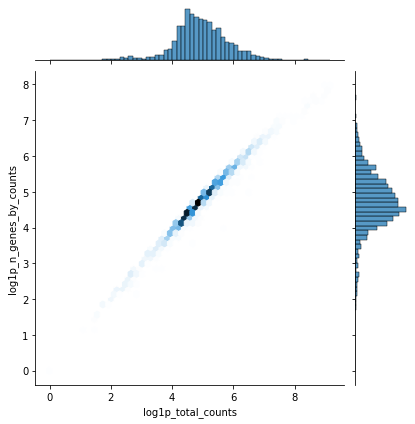

In [33]:
sns.jointplot(
    data=adata_vis.obs,
    x="log1p_total_counts",
    y="log1p_n_genes_by_counts",
    kind="hex",
)

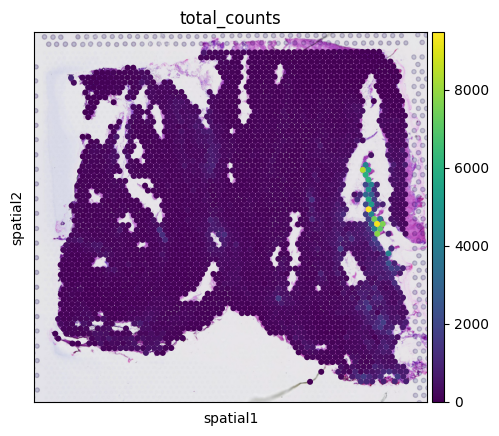

In [29]:
sc.pl.spatial(adata_vis, img_key="hires", color='total_counts', spot_size=40)

In [8]:
# Read h5ad single-cell data
adata_ref = sc.read_h5ad('./data/Hamstring/Ham_int_lab_july2022.h5ad')
adata_ref

AnnData object with n_obs × n_vars = 11894 × 23318
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nUMI', 'nGene', 'log10GenesPerUMI', 'sample', 'mtUMI', 'mitoRatio', 'sex', 'age', 'surgery', 'batch', 'side', 'RNA_snn_res.0.2', 'seurat_clusters', 'cell_type'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_harmony', 'X_pca', 'X_tsne', 'X_umap'

/opt/lramosmu/miniconda3/envs/test_scvi16_cuda113/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


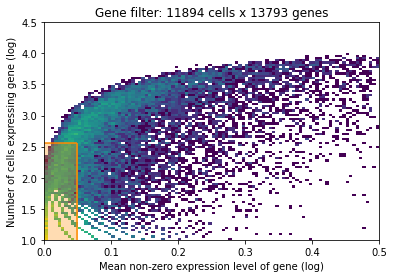

In [10]:
from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

# filter the object
adata_ref = adata_ref[:, selected].copy()

In [11]:
# prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(adata=adata_ref,
                        # 10X reaction / sample / batch
                        batch_key='sample',
                        # cell type, covariate used for constructing signatures
                        labels_key='cell_type'
                        # multiplicative technical effects (platform, 3' vs 5', donor effect)
                        # categorical_covariate_keys=['Method']
                       )

/opt/lramosmu/miniconda3/envs/test_scvi16_cuda113/lib/python3.9/site-packages/scvi/data/_utils.py:102: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  warnings.warn(


In [12]:
# create the regression model
from cell2location.models import RegressionModel
mod = RegressionModel(adata_ref)

# view anndata_setup as a sanity check
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.16.2.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': 'cell_type',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_cells          │ 11894 │
│          n_vars          │ 13793 │
│         n_batch          │   4   │
│         n_labels         │  12   │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
│    ind_x     │   adata.obs['_indices']   │
└──────────────┴───────────────────────────┘

                   batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │ Hamstring0 │          0          │
│                     │ Hamstring1 │          1          │
│                     │ Hamstring2 │          2          │
│                     │ Hamstring5 │          3          │
└─────────────────────┴────────────┴─────────────────────┘

                         labels State Registry                          
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃      Categories       ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cell_type'] │  TNNT3+ TRDN+ cells   │          0          │
│                        │   FBLN+ Fibroblasts   │          1          │
│                        │  TNNT1+ TRDN+ cells   │          2          │
│                        │   MKX+ Fibroblasts    │          3          │
│                        │ COL22A1+ TRDN+ cells  │          4          │
│                        │ Vascular endothelium  │          5          │
│                        │    Satellite cells    │          6          │
│                        │      Mural cells      │          7          │
│                        │ Lymphatic endothelium │          8          │
│                        │  Smooth Muscle Cells  │          9          │
│                        │      Adipocytes       │         10          │
│                        │     Immune cells      │         11          │
└────────────────────────┴───────────────────────┴─────────────────────┘

In [22]:
mod.train(max_epochs=250, use_gpu=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/opt/lramosmu/miniconda3/envs/test_scvi16_cuda113/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/lramosmu/miniconda3/envs/test_scvi16_cuda113/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (5) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 1/250:   0%|                                      | 0/250 [00:00<?, ?it/s]

/opt/lramosmu/miniconda3/envs/test_scvi16_cuda113/lib/python3.9/site-packages/torch/distributions/gamma.py:71: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /opt/lramosmu/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/cuda/jit_utils.cpp:860.)
  self.rate * value - torch.lgamma(self.concentration))


Epoch 250/250: 100%|█| 250/250 [03:22<00:00,  1.24it/s, v_num=1, elbo_train=6.59


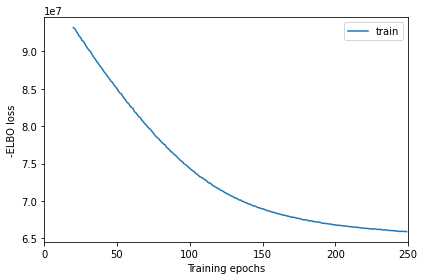

In [23]:
mod.plot_history(20)

In [24]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_ref = mod.export_posterior(
    adata_ref, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True}
)

# Save model
mod.save(f"{ref_run_name}", overwrite=True)

# Save anndata object with results
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref.write(adata_file)
adata_file

Sampling global variables, sample: 100%|█████| 999/999 [00:06<00:00, 159.51it/s]


'./results/hamstring_aug2022//reference_signatures/sc.h5ad'

In [2]:
#Load adata file from previous run....
adata_ref = sc.read_h5ad('./hamstring_aug2022_results/reference_signatures/sc.h5ad')
adata_ref

AnnData object with n_obs × n_vars = 11894 × 13793
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nUMI', 'nGene', 'log10GenesPerUMI', 'sample', 'mtUMI', 'mitoRatio', 'sex', 'age', 'surgery', 'batch', 'side', 'RNA_snn_res.0.2', 'seurat_clusters', 'cell_type', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'n_cells', 'nonz_mean'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'mod'
    obsm: 'X_harmony', 'X_pca', 'X_tsne', 'X_umap'
    varm: 'means_per_cluster_mu_fg', 'q05_per_cluster_mu_fg', 'q95_per_cluster_mu_fg', 'stds_per_cluster_mu_fg'

In [36]:
mod.plot_QC()

RuntimeError: self.samples is missing, please run self.export_posterior() first

In [37]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

,TNNT3+ TRDN+ cells,FBLN+ Fibroblasts,TNNT1+ TRDN+ cells,MKX+ Fibroblasts,COL22A1+ TRDN+ cells
ENSG00000001460,0.020613,0.024176,0.019598,0.017920,0.017719
ENSG00000001461,0.001413,0.034623,0.014267,0.017568,0.018048
ENSG00000010072,0.026542,0.026739,0.036494,0.012873,0.037491
ENSG00000009780,0.106034,0.141353,0.126629,0.094283,0.093233
ENSG00000048707,1.226535,0.773368,1.419366,0.711747,1.287817


In [38]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key="sample")

In [45]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology: default was 30, i tried 5 better, now trying 3.
    N_cells_per_location=3,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection: #original was 20, for tissues with high technical effects. 200 was terrible. Now trying 10.
    detection_alpha=10
)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.16.2.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_cells          │ 2981  │
│          n_vars          │ 13167 │
│         n_batch          │   1   │
│         n_labels         │   1   │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
│    ind_x     │   adata.obs['_indices']   │
└──────────────┴───────────────────────────┘

                   batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │    Ham1    │          0          │
└─────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/opt/lramosmu/miniconda3/envs/test_scvi16_cuda113/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/lramosmu/miniconda3/envs/test_scvi16_cuda113/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 10000/10000: 100%|█| 10000/10000 [10:25<00:00, 15.99it/s, v_num=1, elbo_tr


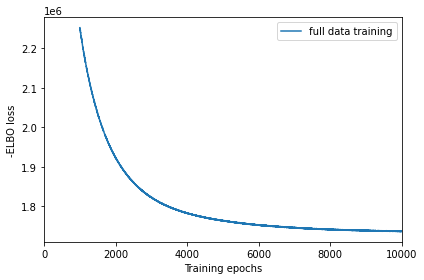

In [46]:
mod.train(max_epochs=10000,
          #usual is 30000
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
          use_gpu=True)

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

In [47]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
)

# Save model
mod.save(f"{run_name}", overwrite=True)

# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

Sampling global variables, sample: 100%|██████| 999/999 [00:11<00:00, 83.68it/s]


'./results/hamstring_aug2022//cell2location_map/sp.h5ad'

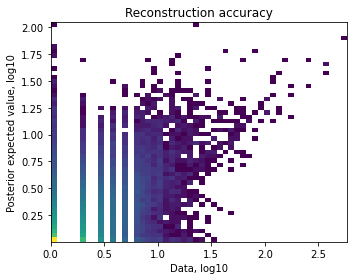

In [48]:
mod.plot_QC()

In [3]:
#Load adata_vis file from previous run....
adata_vis = sc.read_h5ad('./hamstring_aug2022_results/2cellsperspot_10alpha/sp.h5ad')
adata_vis

AnnData object with n_obs × n_vars = 2981 × 13167
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT_gene', 'log1p_total_counts_MT_gene', 'pct_counts_MT_gene', '_indices', '_scvi_batch', '_scvi_labels', 'TNNT3+ TRDN+ cells', 'FBLN+ Fibroblasts', 'TNNT1+ TRDN+ cells', 'MKX+ Fibroblasts', 'COL22A1+ TRDN+ cells', 'Vascular endothelium', 'Satellite cells', 'Mural cells', 'Lymphatic endothelium', 'Smooth Muscle Cells', 'Adipocytes', 'Immune cells'
    var: 'feature_types', 'genome', 'SYMBOL', 'MT_gene', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'mod', 'spatial'
    obsm: 'MT', 'means_cell_abundance_w_sf', 'q05_cell_abundance_w_s

In [13]:
# Now we use cell2location plotter that allows showing multiple cell types in one panel
from cell2location.plt import plot_spatial

# select up to 6 clusters
#clust_labels = ['FBLN+ Fibroblasts', 'MKX+ Fibroblasts', 'Mural cells']
clust_labels = ['FBLN+ Fibroblasts', 'MKX+ Fibroblasts']
clust_col = ['' + str(i) for i in clust_labels] # in case column names differ from labels

slide = select_slide(adata_vis, 'Ham1')

with mpl.rc_context({'figure.figsize': (10, 10)}):
    fig = plot_spatial(
        adata=slide,
        # labels to show on a plot
        color=clust_col, labels=clust_labels,
        show_img=True,
        # 'fast' (white background) or 'dark_background'
        style='fast',
        # limit color scale at 99.2% quantile of cell abundance
        max_color_quantile=0.94,
        # size of locations (adjust depending on figure size)
        circle_diameter=6,
        colorbar_position='right'
    )

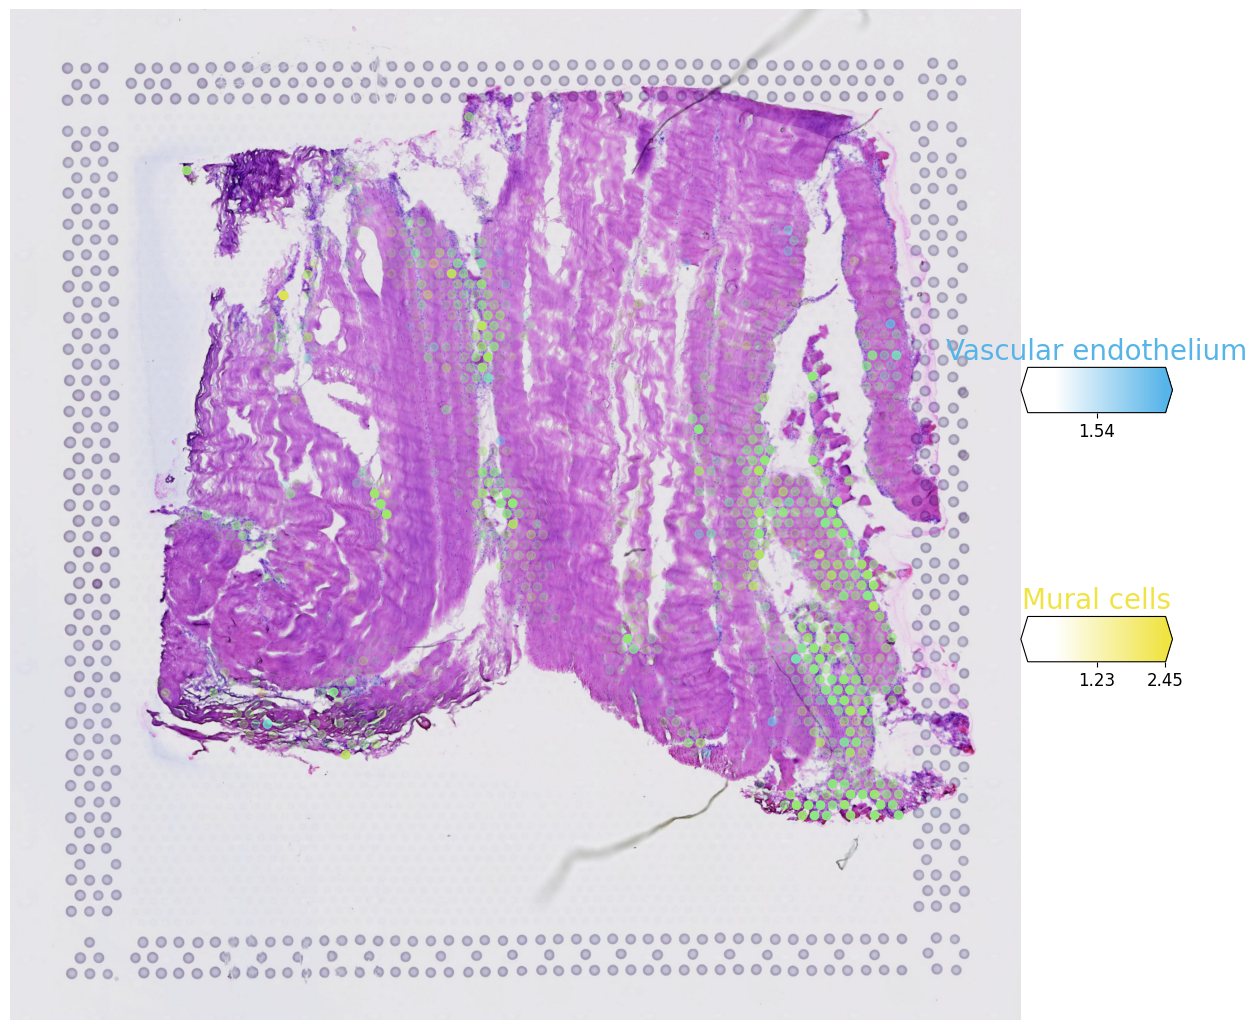

In [32]:
%matplotlib inline
# Now we use cell2location plotter that allows showing multiple cell types in one panel
from cell2location.plt import plot_spatial

# select up to 6 clusters
#clust_labels = ['FBLN+ Fibroblasts', 'MKX+ Fibroblasts', 'Mural cells']
clust_labels = ['Vascular endothelium', 'Mural cells']
clust_col = ['' + str(i) for i in clust_labels] # in case column names differ from labels

slide = select_slide(adata_vis, 'Ham1')

with mpl.rc_context({'figure.figsize': (15, 15)}):
    fig = plot_spatial(
        adata=slide,
        # labels to show on a plot
        color=clust_col, labels=clust_labels,
        show_img=True,
        # 'fast' (white background) or 'dark_background'
        style='fast',
        #scaling color, aka if you want to make it more transparent
        alpha_scaling=1.0,
        #max_col, to set the maximum color for each column
        #max_col=(1.5,1.5),
        #reorder colors of each column
        reorder_cmap=(2,0),
        # limit color scale at 99.2% quantile of cell abundance
        max_color_quantile=0.992,
        # size of locations (adjust depending on figure size)
        circle_diameter=6,
        colorbar_position='right'
    )

In [17]:
adata_vis.obs

,in_tissue,array_row,array_col,sample,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,...,TNNT1+ TRDN+ cells,MKX+ Fibroblasts,COL22A1+ TRDN+ cells,Vascular endothelium,Satellite cells,Mural cells,Lymphatic endothelium,Smooth Muscle Cells,Adipocytes,Immune cells
AAACAAGTATCTCCCA-1,1,50,102,Ham1,153,5.036953,205.0,5.327876,49.756098,74.146341,...,0.032987,0.333129,0.046472,0.746351,0.148120,0.766041,0.033913,0.016397,0.022184,0.290165
AAACACCAATAACTGC-1,1,59,19,Ham1,272,5.609472,408.0,6.013715,41.421569,57.843137,...,0.057693,0.434929,0.076236,1.102139,0.344774,1.158257,0.224868,0.032275,0.067277,0.214883
AAACAGAGCGACTCCT-1,1,14,94,Ham1,130,4.875197,163.0,5.099866,50.920245,81.595092,...,0.024702,0.369812,0.018103,0.616158,0.074573,0.434366,0.014634,0.011612,0.033397,0.116212
AAACAGCTTTCAGAAG-1,1,43,9,Ham1,92,4.532599,102.0,4.634729,58.823529,100.000000,...,0.014671,0.102434,0.024760,0.238045,0.089064,0.377776,0.040807,0.018242,0.010701,0.075455
AAACAGGGTCTATATT-1,1,47,13,Ham1,63,4.158883,75.0,4.330733,82.666667,100.000000,...,0.006251,0.077354,0.007447,0.321099,0.046029,0.190130,0.006633,0.005141,0.007582,0.044784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTCAGTGTGCTAC-1,1,24,64,Ham1,58,4.077537,67.0,4.219508,88.059701,100.000000,...,0.010744,0.083962,0.008347,0.178151,0.037583,0.208133,0.022015,0.005339,0.006312,0.049069
TTGTTGTGTGTCAAGA-1,1,31,77,Ham1,88,4.488636,97.0,4.584968,60.824742,100.000000,...,0.045879,0.151442,0.012430,0.369393,0.078766,0.378082,0.016806,0.009476,0.009341,0.055492
TTGTTTCACATCCAGG-1,1,58,42,Ham1,70,4.262680,80.0,4.394449,75.000000,100.000000,...,0.014409,0.148859,0.011817,0.218742,0.041190,0.263681,0.010814,0.003763,0.006002,0.035212
TTGTTTCATTAGTCTA-1,1,60,30,Ham1,195,5.278115,231.0,5.446737,37.229437,58.874459,...,0.033076,0.260843,0.027138,0.683681,0.411185,0.658284,0.100049,0.014677,0.035539,0.168054


In [ ]:
# plot to check that we have the correct regions

sc.pl.spatial(
    adata_middle_subset,
    img_key="hires",
    library_id = lib_a,
    size=1.5
)

In [26]:
# compute KNN using the cell2location output stored in adata.obsm
sc.pp.neighbors(adata_vis, use_rep='q05_cell_abundance_w_sf',
                n_neighbors = 15)

# Cluster spots into regions using scanpy
sc.tl.leiden(adata_vis, resolution=1.1)

# add region as categorical variable
adata_vis.obs["region_cluster"] = adata_vis.obs["leiden"].astype("category")

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


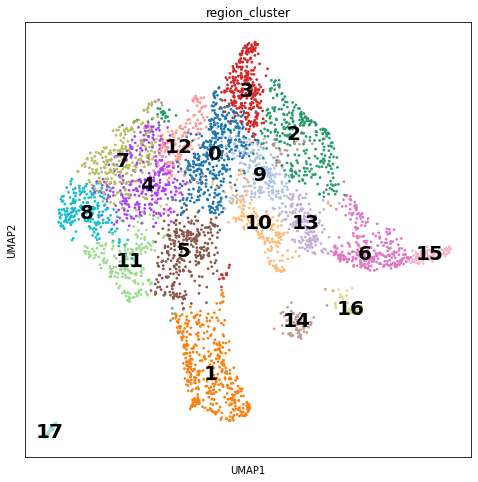

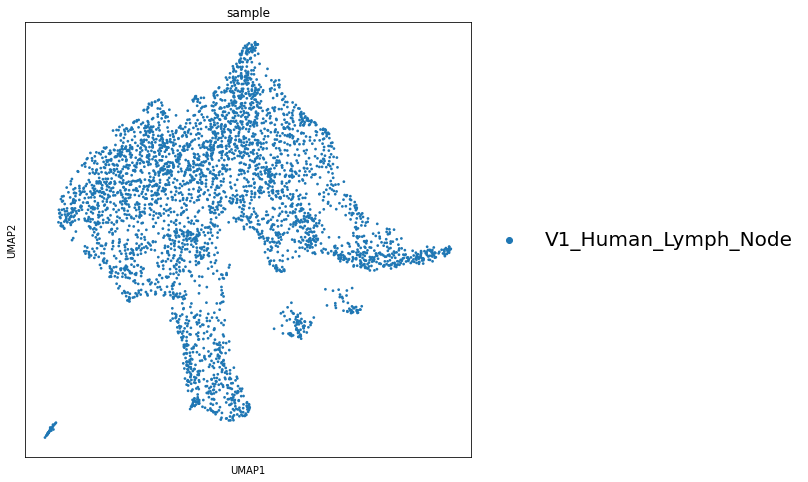

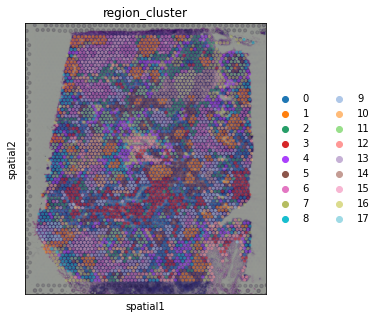

In [27]:
# compute UMAP using KNN graph based on the cell2location output
sc.tl.umap(adata_vis, min_dist = 0.3, spread = 1)

# show regions in UMAP coordinates
with mpl.rc_context({'axes.facecolor':  'white',
                     'figure.figsize': [8, 8]}):
    sc.pl.umap(adata_vis, color=['region_cluster'], size=30,
               color_map = 'RdPu', ncols = 2, legend_loc='on data',
               legend_fontsize=20)
    sc.pl.umap(adata_vis, color=['sample'], size=30,
               color_map = 'RdPu', ncols = 2,
               legend_fontsize=20)

# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):
    sc.pl.spatial(adata_vis, color=['region_cluster'],
                  size=1.3, img_key='hires', alpha=0.5)

In [28]:
from cell2location import run_colocation
res_dict, adata_vis = run_colocation(
    adata_vis,
    model_name='CoLocatedGroupsSklearnNMF',
    train_args={
      'n_fact': np.arange(11, 13), # IMPORTANT: use a wider range of the number of factors (5-30)
      'sample_name_col': 'sample', # columns in adata_vis.obs that identifies sample
      'n_restarts': 3 # number of training restarts
    },
    export_args={'path': f'{run_name}/CoLocatedComb/'}
)

### Analysis name: CoLocatedGroupsSklearnNMF_11combinations_4035locations_34factors


/opt/lramosmu/miniconda3/envs/test_scvi16_cuda113/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/opt/lramosmu/miniconda3/envs/test_scvi16_cuda113/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/opt/lramosmu/miniconda3/envs/test_scvi16_cuda113/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


### Analysis name: CoLocatedGroupsSklearnNMF_12combinations_4035locations_34factors


/opt/lramosmu/miniconda3/envs/test_scvi16_cuda113/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/opt/lramosmu/miniconda3/envs/test_scvi16_cuda113/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/opt/lramosmu/miniconda3/envs/test_scvi16_cuda113/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


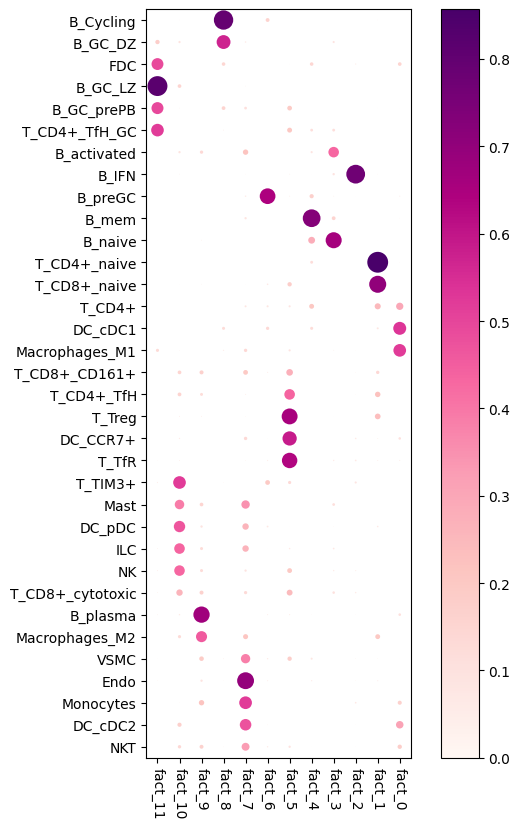

In [29]:
# Here we plot the NMF weights (Same as saved to `cell_type_fractions_heatmap`)
res_dict['n_fact12']['mod'].plot_cell_type_loadings()

In [30]:
# Compute expected expression per cell type
expected_dict = mod.module.model.compute_expected_per_cell_type(
    mod.samples["post_sample_q05"], mod.adata_manager
)

# Add to anndata layers
for i, n in enumerate(mod.factor_names_):
    adata_vis.layers[n] = expected_dict['mu'][i]

# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

'./results/lymph_nodes_analysis//cell2location_map/sp.h5ad'

In [31]:
# list cell types and genes for plotting
ctypes = ['T_CD4+_TfH_GC', 'T_CD4+_naive', 'B_GC_LZ']
genes = ['CD3D', 'CR2']

with mpl.rc_context({'axes.facecolor':  'black'}):
    # select one slide
    slide = select_slide(adata_vis, 'V1_Human_Lymph_Node')

    from tutorial_utils import plot_genes_per_cell_type
    plot_genes_per_cell_type(slide, genes, ctypes);

ModuleNotFoundError: No module named 'tutorial_utils'